In [137]:
import pandas as pd
import matplotlib.pyplot as plt

# load dataset into Pandas DataFrame
df = pd.read_csv("log.csv")
df.columns= ['timestamp','latency','gateway']
df = df.set_index('timestamp')
df = df.sort_index(axis=1)
df.head()


,gateway,latency
timestamp,,
01/21/19 02:32 PM,10.138.25.67,0.339817
01/21/19 02:33 PM,10.138.25.67,0.024861
01/21/19 02:34 PM,10.138.25.67,0.022789
01/21/19 02:35 PM,10.138.25.67,0.022000
01/21/19 02:36 PM,10.138.25.67,0.025834


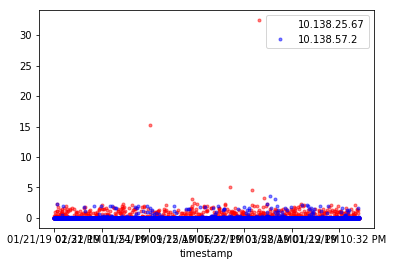

0.026701


In [148]:
fig, ax = plt.subplots()

colors = {'10.138.25.67':'red', '10.138.57.2':'blue'}

grouped = df.groupby('gateway')
for key, group in grouped:
    group.plot(ax=ax, style='.k',  y='latency', label=key, color=colors[key],alpha=0.5)

#plt.ylim(0,5)
plt.show()

print(df['latency'].quantile(0.9))



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os


INPUT_DIR = os.path.join( os.getcwd(), "logs")
data = pd.DataFrame()
dirs = [f for f in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR))]    
#print(dirs)
data = {}
for client in dirs:
    files = [f for f in os.listdir(INPUT_DIR+"/"+client) if os.path.isdir(os.path.join(INPUT_DIR,client))]
    client_data = pd.DataFrame()
    for file in files:
        temp =  pd.read_csv(os.path.join(INPUT_DIR, client,file), sep=',')
        temp.columns= ['timestamp','ttfb','latency','gateway','status']
        client_data = pd.concat([client_data,temp])
    client_data = client_data.set_index(pd.DatetimeIndex(client_data['timestamp']))
    client_data.index = client_data.index.map(lambda x: x.replace(second=0, microsecond=0))
    data[client] = client_data


In [3]:
def get_min_date():
    min_date = None
    for d in data:
        c = data.get(d)
        if min_date is None or min_date > c.index.min():
            min_date = c.index.min()
    return min_date#.strftime("%m/%d/%Y, %H:%M:%S")

def get_max_date():
    max_date = None
    for d in data:
        c = data.get(d)
        if max_date is None or max_date > c.index.max():
            max_date = c.index.max()
    return max_date

def get_90th_percentile():
    df = pd.DataFrame()
    for d in data:
        df = pd.concat([df,data.get(d)])
        
    print(df.describe())
    print(df['latency'].max())
    print(df['latency'].min())
    print(df['latency'].mean())
    return df['latency'].quantile(0.9)

def send_info(ts):
    min_date = None
    max_date = None
    
    gateway_table = pd.DataFrame()
    for d in data:
        c = data.get(d)[ts]
        c['sender'] = d
        if len(c)>2:
            gateway_table = pd.concat([gateway_table , c.sample(n=2)])
        elif len(c)>0:
            gateway_table = pd.concat([gateway_table , c])
    #print(gateway_table)
    return gateway_table
    
import numpy as np
import math
def cosine_similarity(a,b):
    return sum([i*j for i,j in zip(a, b)])/(math.sqrt(sum([i*i for i in a]))* math.sqrt(sum([i*i for i in b])))
    
        
        

In [7]:
import datetime

min_date = get_min_date() 
max_date = get_max_date() 

start = min_date
end_date = start+datetime.timedelta(minutes = 20)
gateway_table = pd.DataFrame()
clients = {}
while(start < end_date):
    rt = send_info(start.strftime("%m/%d/%Y, %H:%M:%S"))
    gws = rt.query('sender=="c1"')['gateway'].values
    
    for index, row in rt.iterrows():
        if row["gateway"] in gws:
            if row['sender'] == "c1":
                continue
            if row["sender"] not in clients:
                clients[row["sender"]] = 1
            else:
                clients[row["sender"]] += 1
    
    
    gateway_table = pd.concat([gateway_table, rt])
    start = start+datetime.timedelta(minutes=2)
    
    print(clients)


/home/khulan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


{}
{'c2': 1}
{'c2': 1}
{'c2': 1, 'c4': 1}
{'c2': 2, 'c4': 1}
{'c2': 2, 'c4': 2}
{'c2': 2, 'c4': 2}
{'c2': 2, 'c4': 3}
{'c2': 2, 'c4': 3, 'c3': 1}
{'c2': 3, 'c4': 4, 'c3': 1}


In [189]:
print(get_90th_percentile())

               ttfb       latency        status
count  1.587320e+06  1.587320e+06  1.587320e+06
mean   1.402278e-01  1.148811e+00  1.921008e+02
std    2.575638e+00  1.052324e+01  6.344121e+01
min    0.000000e+00  5.500000e-05  0.000000e+00
25%    7.339000e-03  2.373300e-02  2.000000e+02
50%    1.242000e-02  5.363600e-02  2.000000e+02
75%    5.962400e-02  3.569230e-01  2.000000e+02
max    1.744037e+02  1.800233e+02  4.070000e+02
180.023293
5.5e-05
1.148810713055306
0.8737531000000002


In [16]:
cosine_similarity([0.189146],[0.171295])

1.0